In [1]:
import os
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(context='notebook', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

In [2]:
import torch
torch.cuda.is_available()

True

In [158]:
gapn_data_file = "20210831-GapN-data-up-to-SM130.csv"
df = pd.read_csv(gapn_data_file, index_col=0)
df = df.dropna()
# drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
df['Sequence'] = df['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', '').strip('*'))
df.head(2)

,Sequence,WT_mutations,NAD+_initial_rate,NADP+_initial_rate
pSM038,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,G209V,0.80667,39.055556
pSM050,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,K176F + S210E,-0.00333,1.566667


In [157]:
# extract the mutations for each sequence
seq_mutations = df['WT_mutations'].apply(lambda x: [mut.strip() for mut in x.split(' + ')])
seq_mutations.head(2)

pSM038           [G209V]
pSM050    [K176F, S210E]
Name: WT_mutations, dtype: object

In [88]:
from collections import defaultdict
mut_counts = defaultdict(int)
for muts in seq_mutations.values:
    if 'F152W' in 
    for mut in muts:
        mut_counts[mut] += 1
# mutations = set([mut for muts in seq_mutations.values for mut in muts])
# mutations
mut_counts

defaultdict(int,
            {'G209V': 29,
             'K176F': 8,
             'S210E': 14,
             'T179E': 28,
             'T179F': 1,
             'G209E': 1,
             'K176H': 3,
             'N153A': 5,
             'P151A': 3,
             'Q180I': 3,
             'P151S': 4,
             'R208W': 1,
             'I212V': 3,
             'I149V': 3,
             'K176W': 2,
             'G209A': 8,
             'R208L': 1,
             'G209H': 1,
             'I149F': 1,
             'K176I': 1,
             'P178D': 3,
             'T179V': 1,
             'G209M': 1,
             'K176M': 1,
             'P177L': 1,
             'P178S': 25,
             'T179S': 5,
             'G207V': 2,
             'R208P': 2,
             'I233V': 2,
             'I233T': 2,
             'P178N': 2,
             'P178T': 2,
             'F152N': 2,
             'F152Q': 2,
             'P178A': 13,
             'T179Q': 10,
             'T179N': 3,
             'R208Y': 8,
  

In [165]:
print(f"{len(mut_counts)} unique mutations over "
      f"{len(set([m[1:-1] for m in mut_counts]))} positions")

41 unique mutations over 16 positions


<AxesSubplot:ylabel='Frequency'>

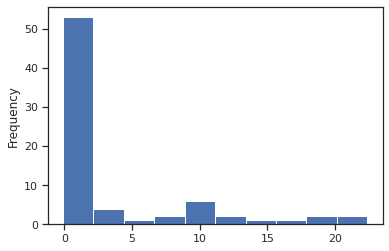

In [4]:
df['NAD+_initial_rate'].plot.hist()

In [6]:
model_name = "esm1_t6_43M_UR50S"
# model_name = "esm1b_t33_650M_UR50S"
torch.hub.set_dir('/tmp/.cache/torch')
# torch.hub.set_dir('/gpfs/alpine/scratch/jlaw/bie108/torch/hub')
# TODO Try this model: esm1v_t33_650M_UR90S
model, alphabet = torch.hub.load("facebookresearch/esm", model_name)

batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(list(df['Sequence'].items()))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Using batch size 8")
batch_dataloader = torch.utils.data.DataLoader(batch_tokens, batch_size=8)

output = []
with torch.no_grad():
    for batch in tqdm(batch_dataloader):
        result = model(batch.to(device), repr_layers=[6])  # because this is the 6-layer transformer
        output += [result['representations'][6].detach().cpu().numpy()]

outputs = np.vstack(output)

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
representations = []
for output, seq in zip(outputs, df['Sequence']):
    representations += [output[1 : len(seq) + 1].mean(0)]
    
representations = np.vstack(representations)
representations.shape

Using cache found in /tmp/.cache/torch/facebookresearch_esm_master


Using batch size 8


100%|██████████| 10/10 [00:00<00:00, 14.96it/s]


(74, 768)

In [67]:
len(output)

477

In [71]:
len(df['Sequence'][3])

476

In [72]:
residue_level_embed = []
for output, seq in zip(outputs, df['Sequence']):
    residue_level_embed += [output[1 : len(seq) + 1]]

In [74]:
# write the representations to file
# out_file = f"{model_name}_gapn_var_embed.npz"
# np.savez(out_file, representations)
out_file = f"{model_name}_gapn_var_residue_embed.npz"
np.savez(out_file, residue_level_embed)

In [167]:
import itertools
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVR
# Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick.
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
# "The form of the model learned by KRR is identical to support vector regression (SVR). 
# However, different loss functions are used: 
# KRR uses squared error loss while support vector regression uses epsilon-insensitive loss, 
# both combined with l2 regularization. In contrast to SVR, fitting a KRR model can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for epsilon > 0, at prediction-time.
from sklearn.kernel_ridge import KernelRidge

# alg = "svr"
alg = 'krr'
kernel = 'laplacian'
normalize_vals = False
wt_nadph = 41.342
# log_transform = True
log_transform = False

# now run K-fold CV using ridge regression
X = representations
y = df['NAD+_initial_rate'].astype(float)
# take the exponent of the training data and predicted probabilities so nothing is < 0

y_train_test = y
if normalize_vals:
    y_train_test = np.asarray([max(0,x/wt_nadph) for x in y])
if log_transform:
    y_train_test = np.asarray([np.log(max(1,x)) for x in y])

In [110]:
# This block has plain cross-validation
kf = KFold(n_splits=5, shuffle=True)

alphas = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.01, 0.1, 1, 10, 100]
# alphas = [.01]
repetitions = 10
best_alpha = 0
best_rmse = 10000
best_y_pred = []
# print("model_name\talpha\tgamma\tavg_slope\tavg_mae\tavg_rmse")
print("model_name\talpha\tavg_slope\tavg_mae\tavg_rmse")
# for alpha, gamma in itertools.product(alphas, gammas):
for alpha in alphas:
    y_preds = []
    maes = []
    rmses = []
    slopes = []
    for rep in range(repetitions):
        y_pred = np.zeros(len(y))
        for train_index, test_index in kf.split(X):
        #     print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_train_test[train_index], y_train_test[test_index]
            if alg == 'krr':
#                 clf = KernelRidge(alpha=alpha, kernel='poly', gamma=gamma)
                clf = KernelRidge(alpha=alpha, kernel=kernel)
            elif alg == "ridge":
                clf = Ridge(alpha=alpha)

            clf.fit(X_train, y_train)
            y_pred[test_index] = clf.predict(X_test)

        y_preds.append(y_pred)
        # mean avg error
        mae = np.sum(np.abs(y_train_test - y_pred))
        # also compute the root mean squared error
        rmse = np.sqrt(np.sum((y_train_test - y_pred)**2) / len(y))
        maes.append(mae)
        rmses.append(rmse)
        # and the slope
        slope, intercept, r_value, p_value, std_err = linregress(y_train_test, y_pred)
        slopes.append(slope)
        
    avg_mae = np.mean(mae)
    avg_slope = np.mean(slopes)
    avg_rmse = np.mean(rmses)
    print(f"{model_name}\t{alpha}\t{gamma}\t{avg_slope:0.2f}\t{avg_mae:0.2f}\t{avg_rmse:0.2f}")
    
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
#         best_alpha = (alpha, gamma)
        best_alpha = alpha
        best_y_pred = y_preds
y_preds = best_y_pred
print(f"best_rmse: {best_rmse:0.2f}, best_alpha: {str(best_alpha)}")

KFold(n_splits=5, random_state=None, shuffle=True)
model_name	alpha	avg_slope	avg_mae	avg_rmse
esm1_t6_43M_UR50S	1e-06	100	0.75	122.17	2.70
esm1_t6_43M_UR50S	1e-05	100	0.74	131.39	2.78
esm1_t6_43M_UR50S	0.0001	100	0.75	127.97	2.66
esm1_t6_43M_UR50S	0.001	100	0.73	120.30	2.80
esm1_t6_43M_UR50S	0.01	100	0.60	138.42	3.18
esm1_t6_43M_UR50S	0.1	100	0.30	222.88	4.34
esm1_t6_43M_UR50S	1	100	0.06	303.37	5.50
esm1_t6_43M_UR50S	10	100	-0.01	305.91	5.89
best_rmse: 2.66, best_alpha: 0.0001


In [150]:
# another form of validation is if we leave out one variant at a time (e.g., all the sequences with that mutation)
# first make the splits
train_test_splits = []
size_test = []
test_count = defaultdict(int)
for mut in mut_counts:
#     train_seqs, test_seqs = 
    # skip the G209V mutation since it's so common
    if mut == "G209V":
        continue
    train_seqs = [idx for idx, s in enumerate(seq_mutations) if mut not in s]
    test_seqs = [idx for idx, s in enumerate(seq_mutations) if mut in s]
    if len(test_seqs)/len(mut_counts) < .1:
        continue
    for s in test_seqs:
        test_count[s] += 1
#     print(mut, len(train_seqs), len(test_seqs))
    train_test_splits.append((train_seqs, test_seqs))
    size_test.append(len(test_seqs))
#     break

In [151]:
# not all of the sequences are being left out because they don't all have common mutations
len(test_count)

60

In [152]:
# also try leaving out all other sequences with any of the mutations for the current sequence
# first make the splits
train_test_splits = []
size_test = []
test_count = defaultdict(int)
# remove G209V since it's so common
seq_muts2 = {s: set(muts) - set(["G209V"]) for s, muts in dict(seq_mutations).items()}
for s, muts in seq_muts2.items():
    if len(muts) == 0:
        continue
    train_seqs = [idx for idx, (s, muts2) in enumerate(seq_muts2.items()) if len(muts & muts2) == 0]
    test_seqs = [idx for idx, (s, muts2) in enumerate(seq_muts2.items()) if len(muts & muts2) != 0]
#     if len(test_seqs)/len(mut_counts) < .1:
#         continue
    for s in test_seqs:
        test_count[s] += 1
#     print(mut, len(train_seqs), len(test_seqs))
    train_test_splits.append((train_seqs, test_seqs))
    size_test.append(len(test_seqs))
#     break

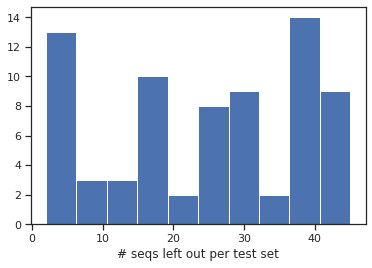

In [153]:
plt.hist(size_test)
plt.xlabel("# seqs left out per test set")
plt.show()

In [154]:
# this block uses mutation-based splits
alphas = [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.01, 0.1, 1, 10, 100]
# alphas = [.01]
repetitions = 10
best_alpha = 0
best_rmse = 10000
best_y_pred = []
# print("model_name\talpha\tgamma\tavg_slope\tavg_mae\tavg_rmse")
print("model_name\talpha\tavg_slope\tavg_mae\tavg_rmse")
# for alpha, gamma in itertools.product(alphas, gammas):
for alpha in alphas:
    y_preds = []
    maes = []
    rmses = []
    slopes = []

    for train_index, test_index in train_test_splits:
        # initialize with numpy nans that shouldn't be included in the plot if they 
        y_pred = np.empty(len(y))
        y_pred[:] = np.nan
    #     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_train_test[train_index], y_train_test[test_index]
        if alg == 'krr':
#                 clf = KernelRidge(alpha=alpha, kernel='poly', gamma=gamma)
            clf = KernelRidge(alpha=alpha, kernel=kernel)
        elif alg == "ridge":
            clf = Ridge(alpha=alpha)

        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)

        y_preds.append(y_pred)
        # mean avg error
        mae = np.sum(np.abs(y_train_test - y_pred))
        # also compute the root mean squared error
        rmse = np.sqrt(np.sum((y_train_test - y_pred)**2) / len(y))
        maes.append(mae)
        rmses.append(rmse)
        # and the slope
        slope, intercept, r_value, p_value, std_err = linregress(y_train_test, y_pred)
        slopes.append(slope)
        
    avg_mae = np.mean(mae)
    avg_slope = np.mean(slopes)
    avg_rmse = np.mean(rmses)
    print(f"{model_name}\t{alpha}\t{gamma}\t{avg_slope:0.2f}\t{avg_mae:0.2f}\t{avg_rmse:0.2f}")
    
    if avg_rmse < best_rmse + 0.01:
#     if avg_rmse < best_rmse:
        best_rmse = avg_rmse
#         best_alpha = (alpha, gamma)
        best_alpha = alpha
        best_y_pred = y_preds
y_preds = best_y_pred
print(f"best_rmse: {best_rmse:0.2f}, best_alpha: {str(best_alpha)}")

model_name	alpha	avg_slope	avg_mae	avg_rmse
esm1_t6_43M_UR50S	1e-06	100	nan	147.77	2.16
esm1_t6_43M_UR50S	1e-05	100	nan	147.80	2.16
esm1_t6_43M_UR50S	0.0001	100	nan	148.14	2.17
esm1_t6_43M_UR50S	0.001	100	nan	151.48	2.19
esm1_t6_43M_UR50S	0.01	100	nan	167.45	2.38
esm1_t6_43M_UR50S	0.1	100	nan	186.08	2.84
esm1_t6_43M_UR50S	1	100	nan	196.94	3.31
esm1_t6_43M_UR50S	10	100	nan	201.26	3.45
best_rmse: 2.17, best_alpha: 0.0001


In [155]:
if log_transform:
    y_preds = [np.exp(ys) for ys in y_preds]
    df2 = pd.DataFrame({'y': np.exp(y_train_test), 'y_pred': np.mean(y_preds, axis=0)})
df2 = pd.DataFrame({'y': y_train_test, 'y_pred': np.nanmean(y_preds, axis=0)})
df2.head(2)

/autofs/nccs-svm1_proj/bie108/jlaw/envs/fairseq-open-ce-1.1.3-py37-0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


,y,y_pred
pSM038,0.80667,NaN
pSM050,-0.00333,-0.596059


/ccs/home/jlaw/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/autofs/nccs-svm1_proj/bie108/jlaw/envs/fairseq-open-ce-1.1.3-py37-0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN axis encountered
  after removing the cwd from sys.path.
/autofs/nccs-svm1_proj/bie108/jlaw/envs/fairseq-open-ce-1.1.3-py37-0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN axis encountered
  """


Text(0.5, 0, 'y')

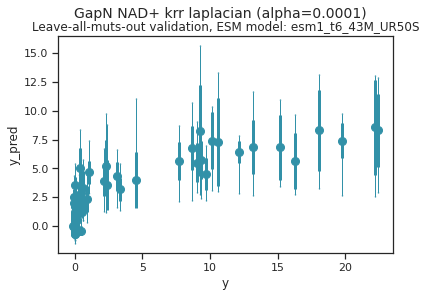

In [156]:
f, ax = plt.subplots()
color = "#3291a8"
std_dev = np.nanstd(y_preds, axis=0)
ax.errorbar(df2['y'], df2['y_pred'], yerr=np.nanmax(y_preds, axis=0) - df2['y_pred'], fmt='o', lolims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=df2['y_pred'] - np.nanmin(y_preds, axis=0), fmt='o', uplims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=std_dev, fmt="o", ms=8, lw=3, color=color)
# df2.plot.scatter(x='y', y="y_pred", s=1, ax=ax)
plt.suptitle(f"GapN NAD+ {alg} {kernel} (alpha={best_alpha})", fontsize=14)
ax.set_title(f"Leave-all-muts-out validation, ESM model: {model_name}", fontsize=12)
ax.set_ylabel("y_pred")
ax.set_xlabel("y")

# out_file = f"viz/gapn-nadh-ridge-{model_name}.svg"
# print(out_file)
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

/ccs/home/jlaw/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/autofs/nccs-svm1_proj/bie108/jlaw/envs/fairseq-open-ce-1.1.3-py37-0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN axis encountered
  after removing the cwd from sys.path.
/autofs/nccs-svm1_proj/bie108/jlaw/envs/fairseq-open-ce-1.1.3-py37-0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN axis encountered
  """


Text(0.5, 0, 'y')

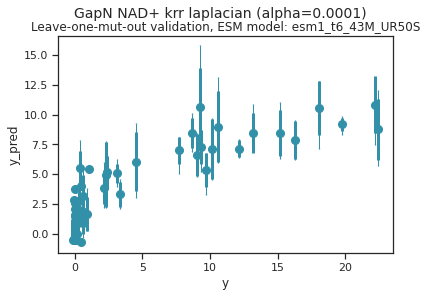

In [141]:
f, ax = plt.subplots()
color = "#3291a8"
std_dev = np.nanstd(y_preds, axis=0)
ax.errorbar(df2['y'], df2['y_pred'], yerr=np.nanmax(y_preds, axis=0) - df2['y_pred'], fmt='o', lolims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=df2['y_pred'] - np.nanmin(y_preds, axis=0), fmt='o', uplims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=std_dev, fmt="o", ms=8, lw=3, color=color)
# df2.plot.scatter(x='y', y="y_pred", s=1, ax=ax)
plt.suptitle(f"GapN NAD+ {alg} {kernel} (alpha={best_alpha})", fontsize=14)
ax.set_title(f"Leave-one-mut-out validation, ESM model: {model_name}", fontsize=12)
ax.set_ylabel("y_pred")
ax.set_xlabel("y")

# out_file = f"viz/gapn-nadh-ridge-{model_name}.svg"
# print(out_file)
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

Text(0.5, 0, 'exp(log y)')

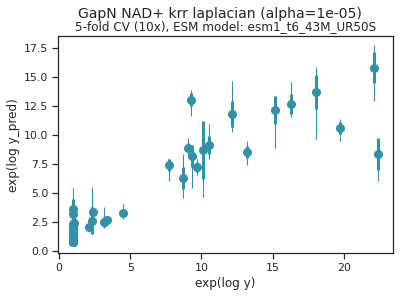

In [63]:
f, ax = plt.subplots()
color = "#3291a8"
std_dev = np.std(y_preds, axis=0)
ax.errorbar(df2['y'], df2['y_pred'], yerr=np.max(y_preds, axis=0) - df2['y_pred'], fmt='o', lolims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=df2['y_pred'] - np.min(y_preds, axis=0), fmt='o', uplims=True, ms=0, lw=1, ls=None, capsize=.5, ecolor=color)
ax.errorbar(df2['y'], df2['y_pred'], yerr=std_dev, fmt="o", ms=8, lw=3, color=color)
# df2.plot.scatter(x='y', y="y_pred", s=1, ax=ax)
plt.suptitle(f"GapN NAD+ {alg} {kernel} (alpha={best_alpha})", fontsize=14)
ax.set_title(f"5-fold CV ({repetitions}x), ESM model: {model_name}", fontsize=12)
ax.set_ylabel("exp(log y_pred)")
ax.set_xlabel("exp(log y)")

# out_file = f"viz/gapn-nadh-ridge-{model_name}.svg"
# print(out_file)
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

(array([ 7.,  7.,  8.,  7.,  9.,  7., 13.,  8.,  3.,  5.]),
 array([-1.93407059, -0.82428169,  0.2855072 ,  1.3952961 ,  2.50508499,
         3.61487389,  4.72466278,  5.83445168,  6.94424057,  8.05402946,
         9.16381836]),
 <BarContainer object of 10 artists>)

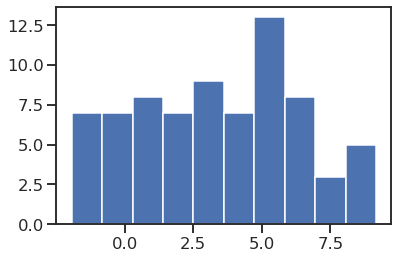

In [21]:
plt.hist(y_pred)
